### Import dependencies and spark session function

In [18]:
import findspark
findspark.init()

import nltk
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, explode, count, udf
from pyspark.ml.feature import Tokenizer
from pyspark.sql.types import ArrayType, StringType
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import os

def create_spark_session(app_name="RedditAnalyzer"):
    """Create a Spark session connected to the cluster"""
    spark = SparkSession \
        .builder \
        .master("spark://g37-master:7077") \
        .appName(app_name) \
        .config("spark.dynamicAllocation.enabled", True) \
        .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
        .config("spark.shuffle.service.enabled", False) \
        .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
        .config("spark.executor.cores", 4) \
        .config("spark.executor.memory", "6g") \
        .config("spark.driver.memory", "6g") \
        .config("spark.default.parallelism", 18) \
        .config("spark.sql.shuffle.partitions", 18) \
        .config("spark.memory.fraction", 0.8) \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "1g") \
        .getOrCreate()
    
    return spark

### Initialize

In [19]:
spark = create_spark_session()

In [20]:
df = spark.read.parquet("hdfs:///data/reddit/clean_corpus.parquet")

df.show(3, truncate=False)
df.printSchema()

[Stage 1:>                                                          (0 + 1) / 1]

+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

code goes here

In [21]:
# Download stopwords if not already installed
nltk.download("stopwords")
nltk_stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# # Load SpaCy's stopwords
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = nlp.Defaults.stop_words
print(spacy_stopwords)




{'whither', 'although', 'empty', '‘d', 'others', 'sixty', 'thence', 'few', 'already', 'mostly', 'can', 'keep', 'anywhere', 'becomes', 'seemed', 'anyone', 'most', 'say', 'per', 'itself', 'two', 'made', 'ourselves', 'somewhere', 'nowhere', 'go', 'various', '‘re', 'via', 'whose', 'elsewhere', 'move', 'neither', 'seems', 'it', 'unless', 'should', 'therein', 'after', 'across', 'full', 'seeming', 'perhaps', 'everything', 'thus', 'really', '’s', 'us', 'were', 'bottom', 'amongst', 'enough', 'or', 'until', 'doing', 'afterwards', 'nevertheless', 'a', 'anything', 'whom', 'meanwhile', 'give', "'ll", "'re", 'least', 'seem', 'further', 'n‘t', 'between', 'show', 'hereby', '’m', 'behind', 'and', 'beyond', 'once', 'nor', 'before', 'over', 'eight', 'never', 'with', 'well', 'also', 'for', 'please', '‘ve', 'fifteen', 'was', 'how', 'without', 'n’t', 'myself', 'where', 'too', 'that', 'be', 'since', 'amount', 'one', 'against', 'everywhere', 'these', 'whence', 'whatever', 'up', 'here', 'make', 'next', 'last',

In [23]:
# Combine both stopword lists

all_stopwords = nltk_stopwords.union(spacy_stopwords)
common_words = set([
    "like", "one", "would", "know", "really", "get", "go", "even", "thing","think", "want", "see", "dont", "make", "going", "got", "use", "way","something", "still", "actually", "much", "many", "take", "need", "say", 
    "work", "good", "bad", "also", "people", "time", "day", "come", "back", "im", "ive", "didn't", "started","pretty","went","little","things","feel", "said", "years","cant","told","right","lot","doesnt","thats","didnt", "getting","long","sure" 
])

# Merge with previous stopwords
all_stopwords = all_stopwords.union(common_words)


In [24]:
# Remove all numbers, special characters, and extra spaces
df_cleaned = df.withColumn("content", regexp_replace(col("content"), "[^a-zA-Z\s]", "")).withColumn("content", regexp_replace(col("content"), "\s+", " "))  # Remove extra spaces


# Tokenize words (split text into words)
tokenizer = Tokenizer(inputCol="content", outputCol="words")
df_tokenized = tokenizer.transform(df_cleaned)

In [25]:
# Define a UDF to remove stopwords
def remove_stopwords(words):
    return [word for word in words if word not in all_stopwords]

# Register UDF in Spark
remove_stopwords_udf = udf(remove_stopwords, ArrayType(StringType()))

# Apply stopword removal on tokenized words
df_filtered = df_tokenized.withColumn("filtered_words", remove_stopwords_udf(df_tokenized["words"]))


In [26]:
# Explode words column to count occurrences
df_words = df_filtered.select(explode(col("filtered_words")).alias("word"))
df_word_count = df_words.groupBy("word").agg(count("word").alias("count"))

# Sort by frequency to find the most common topics
df_sorted_words = df_word_count.orderBy(col("count").desc())

# Show top words
df_sorted_words.show(10)


# Convert Spark DataFrame to Pandas (limit to top 10 words for visualization)
top_words_pd = df_sorted_words.limit(10).toPandas()


+-------+-------+
|   word|  count|
+-------+-------+
|friends|1185330|
|   game|1129170|
|   life| 973164|
|   year| 961464|
|    new| 959739|
|  point| 878055|
| friend| 797165|
| school| 788952|
| better| 784142|
|   help| 782709|
+-------+-------+
only showing top 10 rows



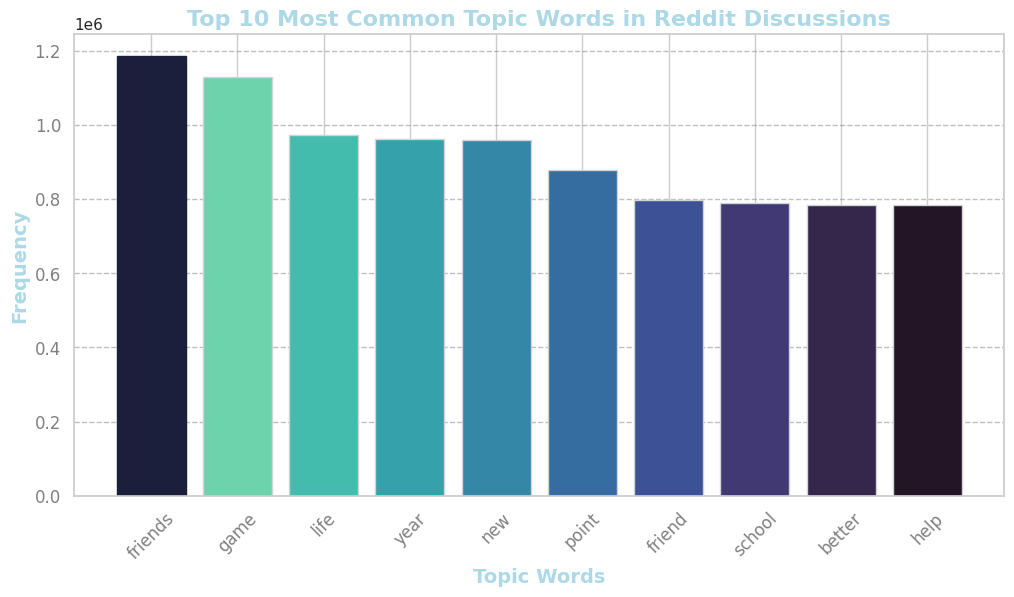

In [27]:
# Set modern theme
sns.set_theme(style="whitegrid")

# Define a dark color palette (Deeper tones from Viridis)
colors = sns.color_palette("mako_r", len(top_words_pd))  # Using "mako" reversed for a dark theme

# Create figure
plt.figure(figsize=(12, 6))
bars = plt.bar(top_words_pd["word"], top_words_pd["count"], color=colors, edgecolor="lightgray")  # Light edge for contrast

# Rotate x labels for better visibility
plt.xticks(rotation=45, fontsize=12, color="gray")
plt.yticks(fontsize=12, color="gray")

# Add labels & title with custom styling
plt.xlabel("Topic Words", fontsize=14, fontweight="bold", color="lightblue")
plt.ylabel("Frequency", fontsize=14, fontweight="bold", color="lightblue")
plt.title("Top 10 Most Common Topic Words in Reddit Discussions", fontsize=16, fontweight="bold", color="lightblue")

# Add grid lines in a subtle dark gray
plt.grid(axis="y", linestyle="--", alpha=0.5, color="gray")

# Highlight the highest bar in an even darker shade for emphasis
bars[0].set_color("#1b1f3b")  # Deep Navy Blue (almost black)

# Show plot
plt.show()


### Shut down spark

In [28]:
spark.stop()

### After this...
1. Commit and push your changes (see `README`)
2. Run `./stop_cluster.sh` on the VM to shut down Spark clusters, HDFS, and Jupyter.